In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("crowdflower/twitter-airline-sentiment")

print("Path to dataset files:", path)

100%|██████████| 2.55M/2.55M [00:00<00:00, 135MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/crowdflower/twitter-airline-sentiment/versions/4


In [ ]:
import pandas as pd
import os

In [ ]:
!pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import re
from transformers import XLNetTokenizer, XLNetForSequenceClassification, TrainingArguments, Trainer, pipeline
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import datasets
import evaluate
import random

In [ ]:
file_path = os.path.join(path, 'Tweets.csv')
df = pd.read_csv(file_path)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
data = df[['airline_sentiment' , 'text']]
data

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,positive,@AmericanAir thank you we got on a different f...
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,@AmericanAir Please bring American Airlines to...
14638,negative,"@AmericanAir you have my money, you change my ..."


<Axes: xlabel='airline_sentiment'>

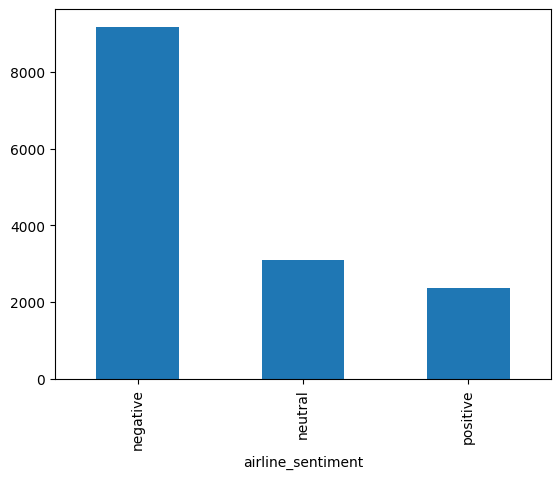

In [ ]:
data['airline_sentiment'].value_counts().plot(kind="bar")

<Axes: xlabel='airline_sentiment'>

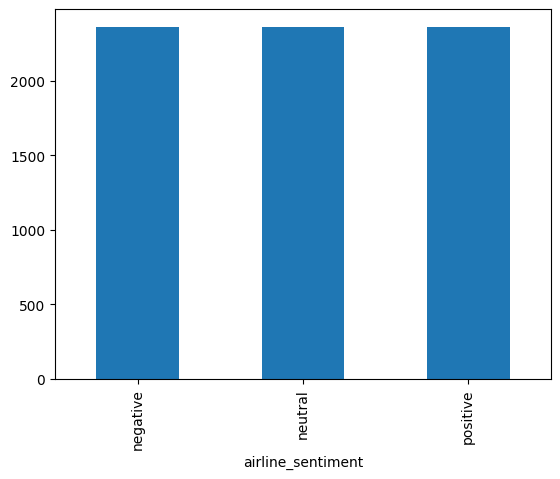

In [ ]:
g = df.groupby('airline_sentiment')
data = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))
data['airline_sentiment'].value_counts().plot(kind="bar")

In [ ]:
data['label'] = data['airline_sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

# Data Cleaning

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
import re

def clean_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove mentions (@user)
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags (but keep the word)
    text = re.sub(r'#(\w+)', r'\1', text)
    # Remove special characters, digits, and punctuations
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize tokens
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back to a single string
    cleaned_text = ' '.join(lemmatized_tokens)
    return cleaned_text

In [ ]:
data['text'] = data['text'].apply(clean_text)

# Splitting data

In [ ]:
train_split, test_split = train_test_split(data, train_size = 0.8)
train_split, val_split = train_test_split(train_split, train_size = 0.9)
print(len(train_split))
print(len(test_split))
print(len(val_split))

5103
1418
568


In [ ]:
train_df = pd.DataFrame({
    "label": train_split.label.values,
    "text": train_split.text.values
})

test_df = pd.DataFrame({
    "label": test_split.label.values,
    "text": test_split.text.values
})

In [ ]:
train_df = datasets.Dataset.from_dict(train_df)
test_df = datasets.Dataset.from_dict(test_df)

In [ ]:
dataset_dict = datasets.DatasetDict({"train":train_df, "test":test_df})

# Tokenization

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding = "max_length", max_length = 128, truncation=True)

In [ ]:
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/5103 [00:00<?, ? examples/s]

Map:   0%|          | 0/1418 [00:00<?, ? examples/s]

# Fine tuninig XLNet

In [ ]:
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased',
                                                       num_labels=3,
                                                       id2label={'negative': 0, 'neutral': 1, 'positive': 2})

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
metric = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch", num_train_epochs=3)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.004000,0.843391,0.612835
2,0.869900,0.754459,0.715797
3,0.738900,0.748147,0.739069


TrainOutput(global_step=1914, training_loss=0.821713629934855, metrics={'train_runtime': 26807.2568, 'train_samples_per_second': 0.571, 'train_steps_per_second': 0.071, 'total_flos': 1090317091288320.0, 'train_loss': 0.821713629934855, 'epoch': 3.0})